In [10]:
from __future__ import print_function
import keras,sklearn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow.compat.v1 as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=4
np.random.seed(seed) # fix random seed
tf.set_random_seed(seed)
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models, regularizers
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GaussianNoise
from keras.preprocessing.image import ImageDataGenerator
from urllib.request import urlopen 
import requests
import io
import time

# Full Comparison
This is the notebook used for the *Full Comparison* section. The following architectures are trained on similar sets and conditions here: ResNet50v2, warshenstein, anna_banana, chris_the_model, jiinnet, and MobileNetv2. 

## Training
Training was over half of the dataset, with 10 epochs, and batchsize of 1024. MobileNetv2 and ResNet50v2 can not take inputs smaller than 32x32x3, so the data is preprocessed to be scaled up by 2 on every side and 3 identical channels were positioned. Therefore they are being fed slightly zoomed out images in both the training and testing. All of the group's models were desiged to take 28x28x1 images, so no preprocessing other than that which was specified by the model's designer was used.

In [11]:
#data loading
all_cat_titles = ['airplane','monalisa','dragon','giraffe','axe','banana','eiffeltower','snail','windmill','snowman','schoolbus','smileyface','lollipop',]

img_rows, img_cols = 28, 28 

use_dataset_titles = ['X_use','Y_use']
ONLYFORFINALCOMPARATIVETEST_DATASETS_DONTYOUFUCKINGTOUCHTHESE = ['X_onlytest','Y_onlytest']
#DONT YOU DARE TOUCH THE ONLYTEST FILES.
#IF YOU ARE TRAINING A NEURAL NETWORK, TRAIN, VALIDATE, AND TEST FROM THE 'USE' FILES.

#load data
url_main = 'https://physics.bu.edu/~warsh/ML_QD/'
datalib={}

#loading samples
response = requests.get(url_main + use_dataset_titles[0] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
data = data.reshape(data.shape[0], img_rows*img_cols)
datalib[use_dataset_titles[0]] = data

response = requests.get(url_main + use_dataset_titles[1] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
datalib[use_dataset_titles[1]] = data

response = requests.get(url_main + 'ot1' +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
data = data.reshape(data.shape[0], img_rows*img_cols)
datalib[ONLYFORFINALCOMPARATIVETEST_DATASETS_DONTYOUFUCKINGTOUCHTHESE[0]] = data

response = requests.get(url_main + 'ot2' +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
datalib[ONLYFORFINALCOMPARATIVETEST_DATASETS_DONTYOUFUCKINGTOUCHTHESE[1]] = data

num_classes = int(max(datalib['Y_use'])+1)
cat_titles = all_cat_titles[:num_classes]
print('loaded:',cat_titles)

loaded: ['airplane', 'monalisa', 'dragon', 'giraffe', 'axe', 'banana', 'eiffeltower', 'snail', 'windmill', 'snowman']


an example of a data point with label banana


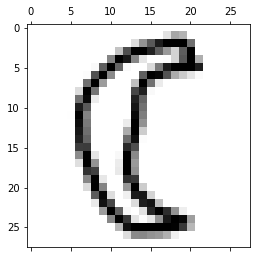

an example of a data point with label airplane


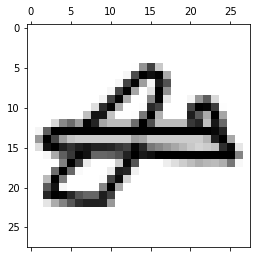

X_train shape: (431574, 28, 28, 1)
Y_train shape: (431574, 10)
X_valid shape: (107893, 28, 28, 1)
Y_valid shape: (107893, 10)
X_test shape: (134867, 28, 28, 1)
Y_test shape: (134867, 10)

431574 train samples
107893 validation samples
134867 test samples
674334 total
X_ot shape: (337168, 28, 28, 1)
Y_ot shape: (337168, 10)


In [12]:
#data shaping
Y_use = datalib['Y_use']
X_use = datalib['X_use']

#format, delegate, and scale data
ratio_use=.5
#use small portion, randomized already:
numosamps = len(Y_use)*ratio_use #number of samples used for train, validation, and testsets
test_size=.2 #20% test
tr2valr=.8 #64% train, 16% validation
num_classes=int(max(Y_use)+1)

#scramble and split!
X_tr, X_test, Y_tr, Y_test = train_test_split(X_use, Y_use, test_size=test_size, train_size=1.0-test_size)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr,Y_tr,train_size=tr2valr,test_size=1-tr2valr)

#how much we usin'
X_train = X_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
Y_train = Y_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
X_valid = X_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
Y_valid = Y_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
X_test = X_test[0:int(numosamps*test_size)]
Y_test = Y_test[0:int(numosamps*test_size)]

#reshape into 2D
X_train = X_train.reshape(X_train.shape[0],img_rows,img_cols)
X_valid = X_valid.reshape(X_valid.shape[0],img_rows,img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows,img_cols)

#yeah okay some floats
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

#scale onto the fun zer-O to O-ne inverval
X_train /= 255
X_valid /= 255
X_test /= 255

X_train_IS = X_train
X_valid_IS = X_valid
X_test_IS = X_test

def channel_and_size(X_t,pv,nchan):
    pad=int((pv-28)/2)
    npad = ((0, 0), (pad, pad), (pad, pad))
    #pad to proper image size - alternatives could be resize up, but I chose just a pad
    X_t = np.pad(X_t, pad_width=npad, mode='constant', constant_values=0)
    #add channels
    X_t = np.stack((X_t,)*nchan, axis=-1)
    return X_t

#display some stuff
for i in range(2):
    print('an example of a data point with label', cat_titles[int(Y_train[i])])
    plt.matshow(X_train[i,:],cmap='binary')
    plt.show()

# converting the actual numbers to the the one-hot vectors
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
Y_valid = keras.utils.to_categorical(Y_valid, num_classes)

#reshape data, depending on Keras backend, final data formatting
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols,1)
    input_shape = (img_rows, img_cols, 1)

#more debugging shit
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_valid shape:', X_valid.shape)
print('Y_valid shape:', Y_valid.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

print(X_train.shape[0]+X_valid.shape[0]+X_test.shape[0], 'total')

Y_ot = datalib['Y_onlytest']
X_ot = datalib['X_onlytest']

#reshape into 2D
X_ot = X_ot.reshape(X_ot.shape[0],img_rows,img_cols)

#yeah okay some floats
X_ot = X_ot.astype('float32')

#scale onto the fun zer-O to O-ne inverval
X_ot /= 255
X_ot_IS = X_ot
# converting the actual numbers to the the one-hot vectors
Y_ot = keras.utils.to_categorical(Y_ot, num_classes)

#reshape data, depending on Keras backend, final data formatting
if keras.backend.image_data_format() == 'channels_first':
    X_ot = X_ot.reshape(X_ot.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_ot = X_ot.reshape(X_ot.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#more debugging shit
print('X_ot shape:', X_ot.shape)
print('Y_ot shape:', Y_ot.shape)

In [13]:
#load and train architectures on same X_train, X_valid, and X_test sets from the X_use and Y_use sets that we all used to design our architectures.
allmodels={}
allhistory={}
allscores={}
masterTestScores={}

#all models evaluated over 10 epochs with batchsize of 512
batch=1024
ep=10

In [ ]:
#load and train ResNet50V2
name='model_RN50V2_comp'
from keras.applications.resnet_v2 import ResNet50V2
channels = 3
imgsize=32
#give data 3 channels to input into ResNet50V2 Architecture
X_train_MN = channel_and_size(X_train_IS,imgsize,channels)
X_valid_MN = channel_and_size(X_valid_IS,imgsize,channels)
X_test_MN = channel_and_size(X_test_IS,imgsize,channels)

#transfer learning to ResNet50V2
model = Sequential()
model.add(ResNet50V2(include_top=False, input_shape=(imgsize,imgsize,channels), pooling='avg'))
model.add(Dense(num_classes,activation="softmax"))
model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
model.summary()

allmodels[name] = model
allhistory[name] = allmodels[name].fit(X_train_MN, Y_train, batch_size=batch,epochs=ep,verbose=1,validation_data=(X_valid_MN, Y_valid))

allmodels[name].save('model_RN50V2.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test_MN, Y_test, verbose=1)
print(allscores[name])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,585,290
Trainable params: 23,539,850
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 1226s 3s/step - loss: 0.2155 - accuracy: 0.9363 - val_loss: 0.1736 - val_accuracy: 0.9506
Epoch 2/10
422/422 [==============================] - 1244s 3s/step - loss: 0.1312 - accuracy: 0.9611 - val_loss: 0.1435 - val_accuracy: 0.9581
Epoch 3/10
422/422 [==============================] - 1229s 3s/step - loss: 0.1144 - accuracy: 0.9655 - val_loss: 0.1440 - val_accuracy: 0.9574
Epoch 4/10
422/422 [==============================] - 1206s 3s/step -

In [ ]:
#warsh
name = 'warshenstein_comp'
def warsh_creation(el1,el2,opti,lays):
    model = Sequential(name='warshenstein_comp')
    model.add(Conv2D(lays, kernel_size=(3, 3), activation='relu', input_shape=input_shape,
                     padding='same', kernel_regularizer=regularizers.l1_l2(l1=el1, l2=el2)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(lays*2, kernel_size=(3, 3), activation='relu', input_shape=input_shape,
                     padding='same', kernel_regularizer=regularizers.l1_l2(l1=el1, l2=el2)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(lays*2*2, kernel_size=(3, 3), activation='relu', input_shape=input_shape,
                     padding='same', kernel_regularizer=regularizers.l1_l2(l1=el1, l2=el2)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(lays*2*2*2,activation="relu"))
    model.add(Dense(num_classes,activation="softmax"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opti,
                  metrics=['accuracy'])
    model.summary()
    return model

lays=64 # still reasonable trainging time
el1=0
el2=0 #found regularization + batchnorm would give worse results, decided to stick to batchnorm
opti='Adam' #gave best results of all optimizers attempted, next best was Adamax.
allmodels[name] = warsh_creation(el1,el2,opti,lays)

#data augmentation, values found through gridsearch
dataAug = ImageDataGenerator(rotation_range = 12, zoom_range = 0.12, width_shift_range = 0.12, height_shift_range = 0.12, horizontal_flip = False, vertical_flip = False)
aug_train = dataAug.flow(X_train, Y_train, batch_size=batch)
aug_valid = dataAug.flow(X_valid, Y_valid, batch_size=batch)
aug_test = dataAug.flow(X_test, Y_test, batch_size=batch)

allhistory[name] = allmodels[name].fit(aug_train, batch_size=batch,epochs=ep,verbose=1,validation_data=(aug_valid))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

print('augmented test: ', allmodels[name].evaluate(aug_test, verbose=1))
allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print('normal test: ',allscores[name])

Model: "warshenstein_comp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)   

In [7]:
#anna
name = 'anna_banana'
def anna_creation():
    # instantiate model
    model = Sequential(name='anna_banana')
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(25, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # add second convolutional layer with 20 filters
    model.add(Conv2D(35, (5, 5), activation='elu'))
    # add third convolutional layer with 25 filters
    model.add(Conv2D(45, (5, 5), activation='relu'))
    # apply dropout with rate
    model.add(Dropout(0.45))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(4, 4)))
    # flatten data
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(20*4*4, activation='relu'))
    # apply dropout
    model.add(Dropout(0.45))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Nadam',
                  metrics=['accuracy'])
    #lil something special to show us our architecture traits
    model.summary()
    return model

allmodels[name] = anna_creation()

allhistory[name] = allmodels[name].fit(X_train, Y_train, batch_size=batch, epochs=ep, verbose=1,validation_data=(X_valid, Y_valid))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test, Y_test, verbose=1)
print(allscores[name])

Model: "anna_banana"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 25)        650       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 25)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 35)          21910     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 45)          39420     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 45)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 45)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 45)                

In [ ]:
#chris
name='chris_the_model_comp'
def chris_creation():
    model = Sequential(name='chris_the_model')
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(20, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, kernel_size=(1, 1),
                     activation='elu',
                     input_shape=input_shape))
    model.add(Conv2D(40, kernel_size=(1, 1),
                     activation='elu',
                     input_shape=input_shape))
    # add second convolutional layer with 20 filters
    model.add(Conv2D(50, (5, 5), activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.35))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(4, 4)))
    # flatten data
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(20*4*4, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.35))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.summary()
    return model

allmodels[name] = chris_creation()

allhistory[name] = allmodels[name].fit(X_train, Y_train, batch_size=batch,epochs=ep,verbose=1,validation_data=(X_valid, Y_valid))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test, Y_test, verbose=1)
print(allscores[name])

Model: "chris_the_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 30)        630       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 40)        1240      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 50)          50050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 50)          0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 50)      

In [ ]:
#jiin
name='jiinnet_comp'
def jiin_creation():
    # instantiate model
    model = Sequential(name='jiinnet')
    model.add(Conv2D(64, kernel_size=(3, 3), strides = 1,
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides = 2, padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    # flatten data
    model.add(Flatten())
    model.add(Dense(800, activation='relu'))
    model.add(Dropout(0.25))
    # soft-max layer
    model.add(Dense(num_classes, activation='softplus'))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    #lil something special to show us our architecture traits
    model.summary()
    return model

allmodels[name] = jiin_creation()

allhistory[name] = allmodels[name].fit(X_train, Y_train, batch_size=batch,epochs=ep,verbose=1,validation_data=(X_valid, Y_valid))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test, Y_test, verbose=1)
print(allscores[name])

Model: "jiinnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0   

In [ ]:
#load and train MobileNetv2
name='model_MNv2_comp'
from keras.applications.mobilenet_v2 import MobileNetV2
channels = 3
imgsize=32
#give data 3 channels to input into MobileNetv2 Architecture
X_train_MN = channel_and_size(X_train_IS,imgsize,channels)
X_valid_MN = channel_and_size(X_valid_IS,imgsize,channels)
X_test_MN = channel_and_size(X_test_IS,imgsize,channels)

#transfer learning to MobileNetv2
model = Sequential()
model.add(MobileNetV2(include_top=False, input_shape=(imgsize,imgsize,channels), pooling='avg'))
model.add(Dense(num_classes,activation="softmax"))
model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
model.summary()

allmodels[name] = model
allhistory[name] = allmodels[name].fit(X_train_MN, Y_train, batch_size=batch,epochs=ep,verbose=1,validation_data=(X_valid_MN, Y_valid))

allmodels[name].save('model_MNV2.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test_MN, Y_test, verbose=1)
print(allscores[name])

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_9 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 290s 687ms/step - loss: 0.2345 - accuracy: 0.9314 - val_loss: 8.7368 - val_accuracy: 0.3933
Epoch 2/10
422/422 [==============================] - 291s 689ms/step - loss: 0.1447 - accuracy: 0.9569 - val_loss: 3.0281 - val_accuracy: 0.6661
Epoch 3/10
422/422 [==============================] - 295s 698ms/step - loss: 0.1280 - accuracy: 0.9619 - val_loss: 1.9992 - val_accuracy: 0.7275


# Testing
All models were tested on the same *only test* dataset which was never touched during the training of the models. The group's models were tested in the first cell, the transfer learned models were tested in the second (this was due to an error with the input.

In [19]:
model_titles = ['warshenstein_comp','anna_banana_comp','chris_the_model_comp','jiinnet_comp','model_RN50V2_comp','model_MNv2_comp']
for keys in allmodels.keys():
  print(keys)

masterTestScores={}
print()
print('testing:')
for mod in model_titles[:4]:
  masterTestScores[mod]=allmodels[mod].evaluate(X_ot,Y_ot,verbose=1)
  print(mod+' acc: %.4f'%masterTestScores[mod][1])

model_RN50V2_comp
warshenstein_comp
anna_banana_comp
chris_the_model_comp
jiinnet_comp
model_MNv2_comp

testing:
10537/10537 [==============================] - 60s 6ms/step - loss: 0.1207 - accuracy: 0.9675
warshenstein_comp acc: 0.9675
10537/10537 [==============================] - 28s 3ms/step - loss: 0.1894 - accuracy: 0.9540
anna_banana_comp acc: 0.9540
10537/10537 [==============================] - 30s 3ms/step - loss: 0.1557 - accuracy: 0.9584
chris_the_model_comp acc: 0.9584
10537/10537 [==============================] - 33s 3ms/step - loss: 0.1245 - accuracy: 0.9636
jiinnet_comp acc: 0.9636


In [ ]:
#altering the test set to fit the 32x32x3 minimum input of Resnet and MobileNet
channels = 3
imgsize=32
X_ot_MN = channel_and_size(X_ot_IS,imgsize,channels)

for mod in model_titles[4:]:
  masterTestScores[mod]=allmodels[mod].evaluate(X_ot_MN,Y_ot,verbose=1)
  print(mod+' acc: %.4f'%masterTestScores[mod][1])

10537/10537 [==============================] - 519s 49ms/step - loss: 0.1619 - accuracy: 0.9571
model_RN50V2_comp acc: 0.9571
10537/10537 [==============================] - 235s 22ms/step - loss: 0.4345 - accuracy: 0.9152
model_MNv2_comp acc: 0.9152


# Results
Warshenstein performed the best in this testing setup.

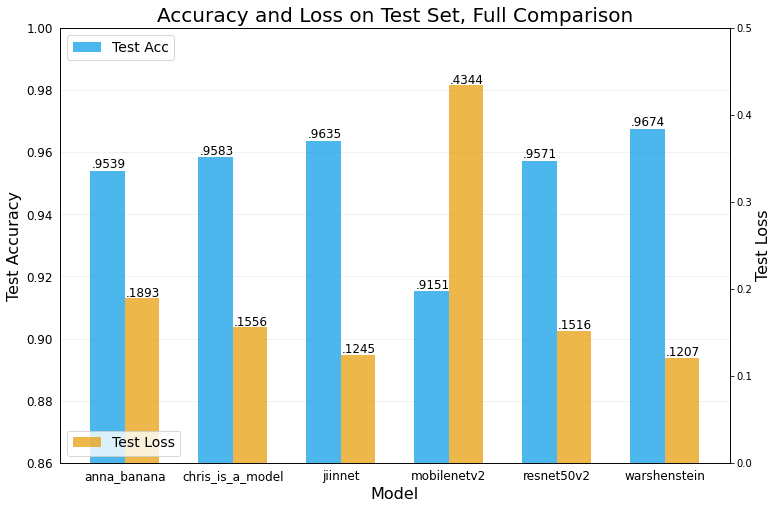

In [21]:
#i am very bad at matplotlib, please do not judge this cell too harshly.
acc = []
loss=[]
for key in masterTestScores.keys():
    acc.append(masterTestScores[key][1])
    loss.append(masterTestScores[key][0])

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(6)

# Define bar width. We need this to offset the second bar.
bar_width = 0.32
a=.7
setcol1=np.array([[0,.6,.9],[.9,.6,0]])
setcol2=np.array([[.6,0,.9],[.9,0,.6]])
b1 = ax.bar(x-.5*bar_width, acc, alpha=a, color=setcol1[0], width=bar_width, label='Test Acc')
ax2 = ax.twinx()
b2 = ax2.bar(x+.5*bar_width, loss, alpha=a, color=setcol1[1], width=bar_width, label='Test Loss')

# Fix the x-axes.
ax.set_xticks(x)
ax.set_xticklabels(['anna_banana','chris_is_a_model','jiinnet','mobilenetv2','resnet50v2','warshenstein'])

ax.legend()
ax.tick_params(bottom=False, left=False, labelsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.text(-.31, .9539+.001, '.9539', fontsize=12)
ax.text(1-.31, .9583+.001, '.9583', fontsize=12)
ax.text(2-.31, .9635+.001, '.9635', fontsize=12)
ax.text(3-.31, .9151+.001, '.9151', fontsize=12)
ax.text(4-.31, .9571+.001, '.9571', fontsize=12)
ax.text(5-.31, .9674+.001, '.9674', fontsize=12)

ax2.text(0.01, .1893+.002, '.1893', fontsize=12)
ax2.text(1+.01, .1556+.002, '.1556', fontsize=12)
ax2.text(2+.01, .1245+.002, '.1245', fontsize=12)
ax2.text(3+.01, .4344+.002, '.4344', fontsize=12)
ax2.text(4+.01, .1516+.002, '.1516', fontsize=12)
ax2.text(5+.01, .1207+.002, '.1207', fontsize=12)

ax.set_xlabel('Model', fontsize=16)
ax.set_ylabel('Test Accuracy', fontsize=16)
ax.set_title('Accuracy and Loss on Test Set, Full Comparison', fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.set_ylim(.86,1)
ax2.set_ylabel('Test Loss', fontsize=16)

ax2.legend(loc="lower left",fontsize=14)
ax2.set_ylim(0,.5)

rects = ax.patches
